<a href="https://colab.research.google.com/github/Yanina-Kutovaya/GNN/blob/main/notebooks/3_GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализация Graph Attention Network (GAT) из PyTorch Geometric для классификации узлов на датасете Bitcoin-OTC с обработкой признаков рёбер

Задача — предсказать "уровень доверия" пользователей

Признаки узлов/рёбер - синтетические

Необходимо выбрать среду выполнения с GPU: Runtime → Change runtime type → GPU

## 1. Установка зависимостей

In [1]:
#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.5 MB/s eta 0:00:00


## 2. Импорт библиотек

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import BitcoinOTC
from torch_geometric.nn import GATConv
import numpy as np

## 3. Загрузка и подготовка данных

Обработка признаков:
* Нормализация степеней узлов
* Стандартизация признаков рёбер
* Явное указание размерности признаков рёбер (edge_dim=1)

In [3]:
dataset = BitcoinOTC(root='data/BitcoinOTC', edge_window_size=10)
data = dataset[0]

Extracting data/BitcoinOTC/raw/soc-sign-bitcoinotc.csv.gz
Processing...
Done!


### 3.1 Создание синтетических признаков узлов

In [4]:
degrees = np.zeros(data.num_nodes)
for edge in data.edge_index.t().tolist():
    degrees[edge[0]] += 1
data.x = torch.tensor(degrees, dtype=torch.float).view(-1, 1)
data.x = (data.x - data.x.mean()) / data.x.std()

### 3.2 Создание меток (3 класса)

In [5]:
labels = torch.zeros(data.num_nodes, dtype=torch.long)
q1 = np.quantile(degrees, 0.33)
q2 = np.quantile(degrees, 0.66)
labels[degrees > q2] = 2
labels[(degrees > q1) & (degrees <= q2)] = 1
data.y = labels

### 3.3 Явное преобразование типа и нормализация признаков рёбер

In [6]:
data.edge_attr = data.edge_attr.to(torch.float32)
data.edge_attr = (data.edge_attr - data.edge_attr.mean()) / data.edge_attr.std()

### 3.4 Разделение данных

In [7]:
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
indices = torch.randperm(data.num_nodes)
split = [0.6, 0.2, 0.2]
data.train_mask[indices[:int(split[0]*data.num_nodes)]] = True
data.val_mask[indices[int(split[0]*data.num_nodes):int((split[0]+split[1])*data.num_nodes)]] = True
data.test_mask[indices[int((split[0]+split[1])*data.num_nodes):]] = True

## 4. Определение модели GAT с использованием признаков рёбер

Архитектура GAT:

* Два слоя GATConv с multi-head attention (8 heads в первом слое)
* Использование признаков рёбер через параметр edge_dim
* ELU-активация и dropout для регуляризации

In [8]:
class BitcoinGAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels, heads=8):
        super().__init__()
        self.conv1 = GATConv(
            in_channels=in_channels,
            out_channels=8,
            heads=heads,
            edge_dim=1,
            dropout=0.6
        )
        self.conv2 = GATConv(
            in_channels=8*heads,
            out_channels=out_channels,
            heads=1,
            edge_dim=1,
            concat=False,
            dropout=0.6
        )
        self.dropout = 0.6

    def forward(self, x, edge_index, edge_attr):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv2(x, edge_index, edge_attr)

## 5. Инициализация модели

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BitcoinGAT(
    in_channels=1,  # 1 признак узла (нормализованная степень)
    out_channels=3  # 3 класса
).to(device)

data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

## 6. Обучение модели

In [10]:
def accuracy(pred, true, mask):
    return (pred[mask].argmax(dim=1) == true[mask]).sum().float() / mask.sum()

model.train()
for epoch in range(300):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Валидация
    model.eval()
    with torch.no_grad():
        val_acc = accuracy(out, data.y, data.val_mask)

    if epoch % 30 == 0:
        print(f'Epoch {epoch:03d} | Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}')

Epoch 000 | Loss: 1.0853 | Val Acc: 0.9292
Epoch 030 | Loss: 0.0392 | Val Acc: 0.9983
Epoch 060 | Loss: 0.0044 | Val Acc: 1.0000
Epoch 090 | Loss: 0.0028 | Val Acc: 1.0000
Epoch 120 | Loss: 0.0022 | Val Acc: 1.0000
Epoch 150 | Loss: 0.0018 | Val Acc: 1.0000
Epoch 180 | Loss: 0.0016 | Val Acc: 1.0000
Epoch 210 | Loss: 0.0014 | Val Acc: 1.0000
Epoch 240 | Loss: 0.0013 | Val Acc: 1.0000
Epoch 270 | Loss: 0.0012 | Val Acc: 1.0000


## 7. Тестирование

In [11]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr)
    test_acc = accuracy(out, data.y, data.test_mask)
    print(f'\nFinal Test Accuracy: {test_acc:.4f}')


Final Test Accuracy: 1.0000


## 8. Визуализация внимания (дополнительно):

In [12]:
# Визуализация весов внимания
model.eval()
_, (edge_index, attention_weights) = model.conv1(data.x, data.edge_index, return_attention_weights=True)

# Для первого узла
node_idx = 0
mask = edge_index[0] == node_idx
related_edges = edge_index[:, mask]
related_weights = attention_weights[mask]

if len(related_weights) == 0:
    print(f"У узла {node_idx} нет соседей.")
else:
    avg_weights = related_weights.mean(dim=1)
    top_n = 5
    actual_n = min(top_n, len(avg_weights))

    top_weights, top_indices = torch.topk(avg_weights, actual_n)

    print(f"\nТоп-{actual_n} важных связей узла {node_idx}:")
    for i in range(actual_n):
        edge_idx = top_indices[i].item()
        source = related_edges[0, edge_idx].item()
        target = related_edges[1, edge_idx].item()
        print(f"{i+1}. {source} → {target} | Вес: {top_weights[i].item():.4f}")


Топ-3 важных связей узла 0:
1. 0 → 14 | Вес: 0.5040
2. 0 → 0 | Вес: 0.2767
3. 0 → 4 | Вес: 0.2387


### 8.1 Визуализация для конкретной головы внимания:

In [13]:
head_idx = 3  # Выбираем 4-ю голову
head_weights = related_weights[:, head_idx]
head_weights

tensor([0.4960, 0.2505, 0.2544], device='cuda:0', grad_fn=<SelectBackward0>)

### 8.2 Сортировка по убыванию веса

In [14]:
# Добавить для явной сортировки
sorted_indices = torch.argsort(avg_weights, descending=True)
sorted_weights = avg_weights[sorted_indices]
sorted_edges = related_edges[:, sorted_indices]

print(f'sorted_indices: {sorted_indices}')
print(f'sorted_weights: {sorted_weights}')
print(f'sorted_edges: {sorted_edges}')

sorted_indices: tensor([0, 2, 1], device='cuda:0')
sorted_weights: tensor([0.5040, 0.2767, 0.2387], device='cuda:0', grad_fn=<IndexBackward0>)
sorted_edges: tensor([[ 0,  0,  0],
        [14,  0,  4]], device='cuda:0')


### 8.3 Визуализация через matplotlib:

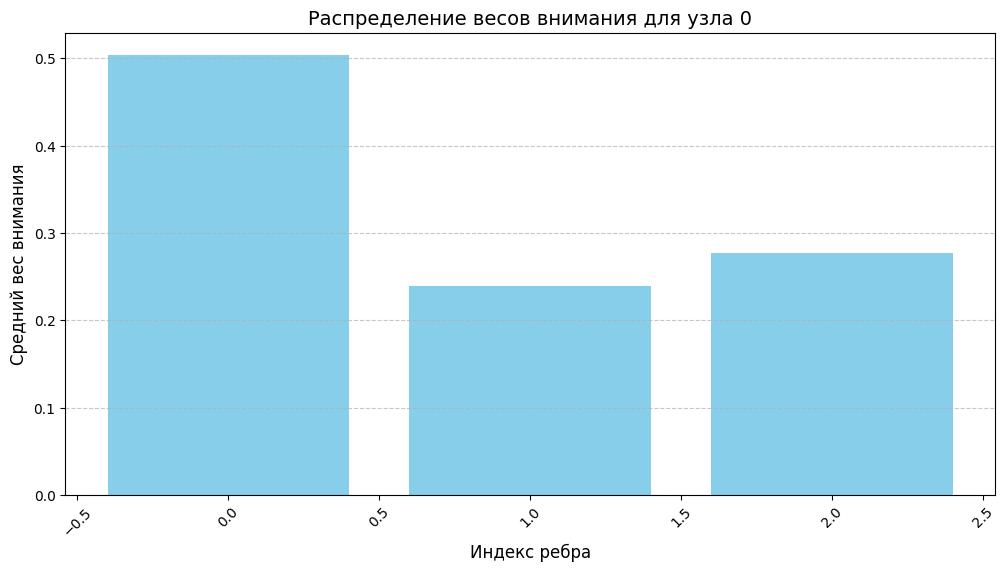

In [15]:
import matplotlib.pyplot as plt

model.eval()
_, (edge_index, attention_weights) = model.conv1(data.x, data.edge_index, return_attention_weights=True)

node_idx = 0
mask = edge_index[0] == node_idx
related_edges = edge_index[:, mask]
related_weights = attention_weights[mask]

if len(related_weights) > 0:
    avg_weights = related_weights.mean(dim=1)

    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.bar(
        x=range(len(avg_weights)),
        height=avg_weights.detach().cpu().numpy(),  # <-- Исправление
        color='skyblue'
    )
    plt.title(f"Распределение весов внимания для узла {node_idx}", fontsize=14)
    plt.xlabel("Индекс ребра", fontsize=12)
    plt.ylabel("Средний вес внимания", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print(f"У узла {node_idx} нет входящих/исходящих связей.")